# Cross-validation and hyper-parameter tuning

In this notebook you will find example `sklearn` ML models estimated on the BBB data. 

In [1]:
import os
from math import sqrt
import numpy as np
import pandas as pd
import pyrsm as rsm
import xgboost as xgb
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import PartialDependenceDisplay as pdp
from sklearn.model_selection import (
    GridSearchCV,
    ShuffleSplit,
    StratifiedShuffleSplit,
)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rsm.__version__ # should be 0.7.9 or higher

# from a terminal run
# pip install --user "pyrsm>=0.7.9"

'0.9.26'

In [3]:
## setup pyrsm for autoreload when you edit code and save
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

Loading the data

In [4]:
bbb = pd.read_pickle("data/bbb.pkl")
bbb

,acctnum,gender,state,zip,zip3,first,last,book,nonbook,total,purch,child,youth,cook,do_it,reference,art,geog,buyer,training
0,10001,M,NY,10605,106,49,29,109,248,357,10,3,2,2,0,1,0,2,no,1
1,10002,M,NY,10960,109,39,27,35,103,138,3,0,1,0,1,0,0,1,no,1
2,10003,F,PA,19146,191,19,15,25,147,172,2,0,0,2,0,0,0,0,no,0
3,10004,F,NJ,07016,070,7,7,15,257,272,1,0,0,0,0,1,0,0,no,0
4,10005,F,NY,10804,108,15,15,15,134,149,1,0,0,1,0,0,0,0,no,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,59996,F,NY,11967,119,9,9,15,12,27,1,1,0,0,0,0,0,0,no,1
49996,59997,F,NJ,08882,088,25,5,79,294,373,7,3,0,1,1,0,1,1,no,1
49997,59998,M,NJ,07410,074,3,3,15,178,193,1,0,0,0,0,1,0,0,no,1
49998,59999,M,NJ,07090,070,49,29,98,246,344,8,2,0,1,0,2,1,2,no,1


Converting categorical variables to 0/1 dummy variables

In [5]:
bbb["buyer_yes"] = rsm.ifelse(bbb.buyer == "yes", 1, 0)
bbb["gender_male"] = rsm.ifelse(bbb.gender == "M", 1, 0)

Adding a random number that should not become an important variable in any model. Setting a random seed to make the results reproducible. Try running the cell below multiple times to confirm

In [6]:
np.random.seed(1234)
bbb["rnd"] = np.random.randn(bbb.shape[0])
bbb["rnd"].head()

0    0.471435
1   -1.190976
2    1.432707
3   -0.312652
4   -0.720589
Name: rnd, dtype: float64

Creating a list of variable names

In [7]:
rvar = "buyer_yes"
evar = [
    "gender_male",
    "last",
    "total",
    "child",
    "youth",
    "cook",
    "do_it",
    "reference",
    "art",
    "geog",
    "rnd",
]
idvar = "acctnum"
lev = "Yes"

In [8]:
X = bbb[evar].copy()
y = bbb[rvar]

By passing information about the training variable to `rsm.scale_df` the variables will be scaled using *only* information from the training sample and you will retain the column headers

In [9]:
rsm.scale_df?

Signature:
rsm.scale_df(
    df,
    wt=None,
    sf=2,
    excl=None,
    train=None,
    ddof=0,
    stats=False,
    means=None,
    stds=None,
)
Docstring:
Scale the numeric variables in a Pandas dataframe

Parameters
----------
df : Pandas dataframe with numeric variables
wt : Pandas series or None
    Weights to use during scaling. The length of the vector should
    be the same as the number of rows in the df
sf : float
    Scale factor to use (default is 2).
excl : None or list
    Provide list of column names to exclude when applying standardization
train : bool
    A series of True and False values. Values that are True are
    used to calculate the mean and standard deviation
stats : bool
    Return the mean and standard deviation for each column
ddof : int, default 0
    Delta Degrees of Freedom. The divisor used in calculations is N - ddof,
    where N represents the number of elements. The default value 0, is
    the same as used by Numpy and sklearn for StandardScaler
me

In [10]:
Xs = rsm.scale_df(X, train=bbb.training == 1, sf=1, excl="gender_male")
pd.DataFrame({"means": Xs[bbb.training == 1].mean(), "stds": Xs[bbb.training == 1].std()}).round(2)

,means,stds
gender_male,0.33,0.47
last,-0.00,1.00
total,-0.00,1.00
child,-0.00,1.00
youth,-0.00,1.00
cook,-0.00,1.00
do_it,0.00,1.00
reference,-0.00,1.00
art,-0.00,1.00
geog,-0.00,1.00


Just as an exercise, we are going to create a new training variable using `ShuffleSplit`. This function from `sklearn` returns a python generator, so we use a loop to extract the relevant values. The training-test split will be 70-30. Note the use of `.copy()` to ensure changes to the training or test data are not reflected back in the bbb dataframe

In [11]:
ssplit = ShuffleSplit(n_splits=1, test_size=0.3, random_state=1234)
for train_index, test_index in ssplit.split(X):
    pass
train_index

array([24515, 21369,  7912, ..., 23924, 34086, 27439])

Notice that the proportion of 1s in `y` is not exactly the same when we use `ShuffleSplit`

In [12]:
X["training"] = 0
X.iloc[train_index, X.columns.get_loc("training")] = 1
print(
    f"Training: {y[X.training == 1].mean():.4f}, Test: {y[X.training == 0].mean():.4f}"
)

Training: 0.0898, Test: 0.0919


`StratifiedShuffleSplit` is a better option to use when creating a training variable because it ensures the proportions of 1s in the training and test set are as close as possible. To demonstrate, we will first uses a 50-50 split. Now the proportions and number of 1s in the training and test set are identical

In [13]:
sssplit = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=1234)
X["training"] = 0
for train_index, test_index in sssplit.split(X, y):
    X.iloc[train_index, X.columns.get_loc("training")] = 1

print(
    f"Training: {y[X.training == 1].mean():.4f}, Test: {y[X.training == 0].mean():.4f}",
    f"\nTraining: {y[X.training == 1].sum():,}, Test: {y[X.training == 0].sum():,}",
)

Training: 0.0904, Test: 0.0904 
Training: 2,261, Test: 2,261


Now re-create the training index so we have a 70-30 split

In [14]:
sssplit = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1234)
for train_index, test_index in sssplit.split(X, y):
    pass

X["training"] = 0
for train_index, test_index in sssplit.split(X, y):
    X.iloc[train_index, X.columns.get_loc("training")] = 1

print(
    f"Training: {y[X.training == 1].mean():.4f}, Test: {y[X.training == 0].mean():.4f}",
    f"\nTraining: {y[X.training == 1].sum():,}, Test: {y[X.training == 0].sum():,}",
    f"\nTraining size: {(X.training == 1).mean():,}, Test size: {(X.training == 0).mean():,}",
)

Training: 0.0904, Test: 0.0905 
Training: 3,165, Test: 1,357 
Training size: 0.7, Test size: 0.3


We will use the new training variable from here on out. We don't want the training variable to be used in estimation, so we will remove it from `X`

In [15]:
training = X.pop("training")

Now we can standardize X and specify the `training` variable so only information from the training data is used in scaling

In [16]:
Xs = rsm.scale_df(X, train=training == 1, excl="gender_male")
Xs

,gender_male,last,total,child,youth,cook,do_it,reference,art,geog,rnd
0,1,1.022903,0.733878,0.955141,1.182377,0.445832,-0.302226,0.573723,-0.282954,0.871340,0.233766
1,1,0.900253,-0.345663,-0.381112,0.447799,-0.395292,0.351539,-0.258621,-0.282954,0.273221,-0.596093
2,0,0.164354,-0.178063,-0.381112,-0.286779,0.445832,-0.302226,-0.258621,-0.282954,-0.324898,0.713624
3,0,-0.326245,0.314878,-0.381112,-0.286779,-0.395292,-0.302226,0.573723,-0.282954,-0.324898,-0.157642
4,0,0.164354,-0.291439,-0.381112,-0.286779,0.025270,-0.302226,-0.258621,-0.282954,-0.324898,-0.361280
...,...,...,...,...,...,...,...,...,...,...,...
49995,0,-0.203595,-0.892827,0.064306,-0.286779,-0.395292,-0.302226,-0.258621,-0.282954,-0.324898,-0.200599
49996,0,-0.448895,0.812748,0.955141,-0.286779,0.025270,0.351539,-0.258621,0.454014,0.273221,-0.204037
49997,1,-0.571545,-0.074545,-0.381112,-0.286779,-0.395292,-0.302226,0.573723,-0.282954,-0.324898,0.753356
49998,1,1.022903,0.669795,0.509723,-0.286779,0.025270,-0.302226,1.406066,0.454014,0.871340,-0.575577


Storing results for evaluation of different models

In [17]:
eval_dat = bbb[[idvar, rvar]].copy()
eval_dat["training"] = training

Lets start with a basic logistic regression model on standardized data

In [18]:
lr = rsm.model.logistic(
    data={"Xs": Xs.assign(buyer_yes=y)[training == 1]},
    rvar="buyer_yes",
    lev=1,
    evar=evar
)
lr.summary()

Logistic regression (GLM)
Data                 : Xs
Response variable    : buyer_yes
Level                : 1
Explanatory variables: gender_male, last, total, child, youth, cook, do_it, reference, art, geog, rnd
Null hyp.: There is no effect of x on buyer_yes
Alt. hyp.: There is an effect of x on buyer_yes

                OR     OR%  coefficient  std.error  z.value p.value     
Intercept    0.041  -95.9%        -3.18      0.035  -92.193  < .001  ***
gender_male  2.131  113.1%         0.76      0.043   17.678  < .001  ***
last         0.204  -79.6%        -1.59      0.055  -28.918  < .001  ***
total        1.219   21.9%         0.20      0.048    4.133  < .001  ***
child        0.647  -35.3%        -0.44      0.047   -9.372  < .001  ***
youth        0.856  -14.4%        -0.16      0.043   -3.630  < .001  ***
cook         0.535  -46.5%        -0.62      0.049  -12.848  < .001  ***
do_it        0.442  -55.8%        -0.82      0.049  -16.601  < .001  ***
reference    1.358   35.8%        

Logistic regression through sklearn without any regularization gives the same ORs as `rsm.model.logistic` above

> Note: I don't recommend using LogisticRegression from sklearn in practice. Use glm from Statsmodels or rsm.model.logistic from pyrsm instead

In [19]:
clf = LogisticRegression(random_state=1234, max_iter=1000, penalty=None).fit(
    Xs[training == 1], y[training == 1]
)

coef = np.concatenate((clf.intercept_, clf.coef_[0]), axis=0)
np.exp(coef).round(4)

array([0.0415, 2.1305, 0.2044, 1.2192, 0.6466, 0.856 , 0.5354, 0.4419,
       1.3582, 5.0143, 2.5506, 0.9738])

Logistic regression through sklearn with *very strong* regularization. Note that if you are using regularization you should *always* standardize your explanatory variables first. The level of regularization is so strong that the coefficients for all explanatory variables have been set to zero

In [20]:
clf = LogisticRegression(
    random_state=1234, max_iter=1000, solver="saga", penalty="l1", C=0.0000001
).fit(Xs[training == 1], y[training == 1])

coef = np.concatenate((clf.intercept_, clf.coef_[0]), axis=0)
np.exp(coef).round(4) # all coefficients are 0 and ORs are 1

array([0.1049, 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    ])

Logistic regression through sklearn with *minimal* regularization gives (almost) the same result as not using any penalty

In [21]:
clf = LogisticRegression(
    random_state=1234, max_iter=1000, solver="saga", penalty="l1", C=100000
).fit(Xs[training == 1], y[training == 1])

coef = np.concatenate((clf.intercept_, clf.coef_[0]), axis=0)
np.exp(coef).round(4)

array([0.0415, 2.1305, 0.2044, 1.2192, 0.6466, 0.856 , 0.5354, 0.4419,
       1.3582, 5.0144, 2.5507, 0.9738])

Logistic regression in sklearn with strong L1 regularization will set the coefficient for the `rnd` variable to zero

In [22]:
clf = LogisticRegression(
    random_state=1234, max_iter=1000, solver="saga", penalty="l1", C=0.05
).fit(Xs[training == 1], y[training == 1])

coef = np.concatenate((clf.intercept_, clf.coef_[0]), axis=0)
coef = pd.DataFrame({"labels": evar, "coefficients": coef[1:], "OR": np.exp(coef[1:])})
coef

,labels,coefficients,OR
0,gender_male,0.704872,2.023588
1,last,-1.511225,0.220640
2,total,0.139106,1.149246
3,child,-0.381726,0.682682
4,youth,-0.115520,0.890902
5,cook,-0.563210,0.569378
6,do_it,-0.745222,0.474629
7,reference,0.270664,1.310835
8,art,1.561671,4.766781
9,geog,0.891454,2.438672


In [23]:
coef.query("coefficients == 0")

,labels,coefficients,OR
10,rnd,0.0,1.0


Storing predictions from LogisticRegression (sklearn)

In [24]:
eval_dat["y_lr"] = clf.predict_proba(Xs)[:, 1]

Tuning logistic regression with L1 penalty (LASSO)

In [25]:
if os.path.exists("cv-objects/lr-cross-validation-object.pkl"):
    lr_cv = rsm.load_state("cv-objects/lr-cross-validation-object.pkl")["lr_cv"]
else:
    clf = LogisticRegression(random_state=1234, max_iter=1000, solver="saga", penalty="l1")
    param_grid = {"C": [1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025]}
    scoring = {"AUC": "roc_auc"}
    lr_cv = GridSearchCV(
        clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
    ).fit(Xs[training == 1], y[training == 1])
    rsm.save_state(
        {"lr_cv": lr_cv}, "cv-objects/lr-cross-validation-object.pkl"
    )

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Display the results from CV for logistic regression with regularization

In [26]:
cv_results = pd.DataFrame(lr_cv.cv_results_).sort_values(by=["rank_test_AUC"])
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
0,0.048024,0.001359,0.002334,0.000213,1,{'C': 1},0.809517,0.818689,0.810102,0.816834,0.813282,0.813685,0.003614,1
1,0.044246,0.001442,0.002080,0.000054,0.5,{'C': 0.5},0.809516,0.818706,0.810029,0.816846,0.813299,0.813679,0.003636,2
2,0.042203,0.001507,0.002012,0.000057,0.25,{'C': 0.25},0.809504,0.818705,0.809942,0.816846,0.813344,0.813668,0.003655,3
3,0.042088,0.001935,0.001919,0.000121,0.1,{'C': 0.1},0.809500,0.818732,0.809662,0.816818,0.813517,0.813646,0.003715,4
4,0.041999,0.002417,0.001956,0.000131,0.05,{'C': 0.05},0.809291,0.818665,0.808997,0.816767,0.813741,0.813492,0.003883,5
5,0.041368,0.001686,0.002156,0.000397,0.025,{'C': 0.025},0.808437,0.818076,0.807428,0.816256,0.813616,0.812763,0.004203,6
6,0.043650,0.002402,0.002163,0.000189,0.01,{'C': 0.01},0.804170,0.815265,0.802119,0.812382,0.809766,0.808740,0.004932,7
7,0.042666,0.003628,0.001963,0.000099,0.005,{'C': 0.005},0.786522,0.800898,0.783626,0.796770,0.792318,0.792027,0.006359,8
8,0.039914,0.002473,0.001807,0.000145,0.0025,{'C': 0.0025},0.765408,0.777231,0.761318,0.774265,0.770765,0.769797,0.005785,9


We now have to use `iloc` because the df has been sorted and .loc[0, "param_C"] might return the wrong row!

In [27]:
cv_results.iloc[0, cv_results.columns.get_loc("param_C")]

1

Note that the random variable ("rnd") was *not* removed or set to 0!

In [28]:
coef = lr_cv.best_estimator_.coef_
pd.DataFrame({"labels": evar, "coefficients": coef[0], "OR": np.exp(coef[0])})

,labels,coefficients,OR
0,gender_male,0.753761,2.124976
1,last,-1.583870,0.205180
2,total,0.195192,1.215545
3,child,-0.433185,0.648441
4,youth,-0.153442,0.857750
5,cook,-0.621593,0.537088
6,do_it,-0.813038,0.443509
7,reference,0.304380,1.355784
8,art,1.609682,5.001221
9,geog,0.934044,2.544779


In [29]:
eval_dat["y_lasso"] = lr_cv.predict_proba(Xs)[:, 1]

Estimate a Neural Net for classification from SKLEARN

In [30]:
clf = MLPClassifier(
    activation="tanh",
    solver="lbfgs",
    alpha=0.01,
    hidden_layer_sizes=(1,),
    random_state=1234,
    max_iter=10000,
).fit(Xs[training == 1], y[training == 1])

In [31]:
eval_dat["y_nn"] = clf.predict_proba(Xs)[:, 1]
eval_dat

,acctnum,buyer_yes,training,y_lr,y_lasso,y_nn
0,10001,0,1,0.020020,0.017953,0.017703
1,10002,0,0,0.017419,0.015877,0.015819
2,10003,0,1,0.017345,0.015487,0.015429
3,10004,0,0,0.073923,0.077197,0.076124
4,10005,0,1,0.021545,0.020111,0.019782
...,...,...,...,...,...,...
49995,59996,0,1,0.036383,0.033690,0.032638
49996,59997,0,1,0.114187,0.112181,0.112373
49997,59998,0,1,0.181453,0.191942,0.195078
49998,59999,0,0,0.124892,0.132982,0.134921


Use CV to tune the NN. Below we tune on the size of the NN the level of regularization

In [32]:
nr_hnodes = range(1, 5)
hls = list(zip(nr_hnodes)) + list(zip(nr_hnodes, nr_hnodes))
hls

[(1,), (2,), (3,), (4,), (1, 1), (2, 2), (3, 3), (4, 4)]

In [33]:
param_grid = {"hidden_layer_sizes": hls, "alpha": [0.001, 0.01, 0.05]}
scoring = {"AUC": "roc_auc"}

In [34]:
if os.path.exists("cv-objects/nn-cross-validation-object.pkl"):
    nn_cv = rsm.load_state("cv-objects/nn-cross-validation-object.pkl")["nn_cv"]
else:
    nn_cv = GridSearchCV(
        clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
    ).fit(Xs[training == 1], y[training == 1])
    rsm.save_state(
        {"nn_cv": nn_cv}, "cv-objects/nn-cross-validation-object.pkl"
    )

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [35]:
nn_cv.best_params_

{'alpha': 0.05, 'hidden_layer_sizes': (3, 3)}

In [36]:
nn_cv.best_score_

0.8181564648484944

In [37]:
cv_results = pd.DataFrame(nn_cv.cv_results_).sort_values(by="rank_test_AUC")
cv_results.iloc[
    0,
    [
        cv_results.columns.get_loc(c)
        for c in ["param_alpha", "param_hidden_layer_sizes"]
    ],
]

param_alpha                   0.05
param_hidden_layer_sizes    (3, 3)
Name: 22, dtype: object

In [38]:
eval_dat["y_nn_cv"] = nn_cv.predict_proba(Xs)[:, 1]
eval_dat

,acctnum,buyer_yes,training,y_lr,y_lasso,y_nn,y_nn_cv
0,10001,0,1,0.020020,0.017953,0.017703,0.011549
1,10002,0,0,0.017419,0.015877,0.015819,0.017550
2,10003,0,1,0.017345,0.015487,0.015429,0.014305
3,10004,0,0,0.073923,0.077197,0.076124,0.073056
4,10005,0,1,0.021545,0.020111,0.019782,0.020388
...,...,...,...,...,...,...,...
49995,59996,0,1,0.036383,0.033690,0.032638,0.033433
49996,59997,0,1,0.114187,0.112181,0.112373,0.095008
49997,59998,0,1,0.181453,0.191942,0.195078,0.210040
49998,59999,0,0,0.124892,0.132982,0.134921,0.154749


In [39]:
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}
rsm.evalbin(
    dct, "buyer_yes", 1, ["y_lr", "y_lasso", "y_nn", "y_nn_cv"], cost=0.5, margin=6
)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,training,y_lr,2356,8624,23211,809,35000,0.744,0.729,0.215,0.333,0.730,0.224,8646.0,0.985,1.575,0.314,0.814
1,training,y_lasso,2342,8501,23334,823,35000,0.740,0.733,0.216,0.334,0.734,0.226,8630.5,0.983,1.592,0.310,0.814
2,training,y_nn,2327,8373,23462,838,35000,0.735,0.737,0.217,0.336,0.737,0.228,8612.0,0.981,1.610,0.306,0.814
3,training,y_nn_cv,2337,8152,23683,828,35000,0.738,0.744,0.223,0.342,0.743,0.236,8777.5,1.000,1.674,0.300,0.822
4,test,y_lr,984,3741,9902,373,15000,0.725,0.726,0.208,0.324,0.726,0.213,3541.5,0.961,1.499,0.315,0.806
5,test,y_lasso,980,3678,9965,377,15000,0.722,0.730,0.210,0.326,0.730,0.216,3551.0,0.964,1.525,0.311,0.806
6,test,y_nn,979,3631,10012,378,15000,0.721,0.734,0.212,0.328,0.733,0.219,3569.0,0.969,1.548,0.307,0.806
7,test,y_nn_cv,993,3553,10090,364,15000,0.732,0.740,0.218,0.336,0.739,0.229,3685.0,1.000,1.621,0.303,0.813


### Decision tree

Estimate a basic decision tree model

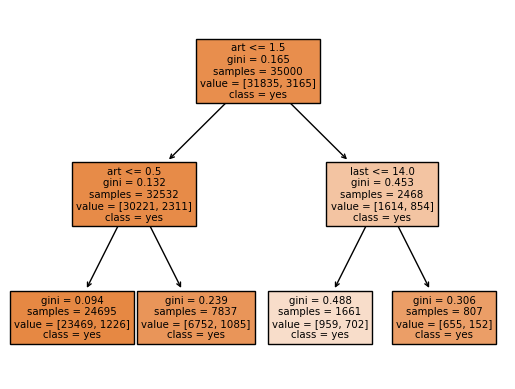

In [40]:
clf = tree.DecisionTreeClassifier(max_depth=2).fit(X[training == 1], y[training == 1])
fig = tree.plot_tree(clf, feature_names=evar, class_names=["yes", "no"], filled=True)

Estimate a larger tree that is likely to ovexgbit the data

In [41]:
clf = tree.DecisionTreeClassifier(max_depth=20).fit(X[training == 1], y[training == 1])

Predict for the entire dataset

In [42]:
eval_dat["y_tree"] = clf.predict_proba(X)[:, 1]

In [43]:
if os.path.exists("cv-objects/dt-cross-validation-object.pkl"):
    dt_cv = rsm.load_state("cv-objects/dt-cross-validation-object.pkl")["dt_cv"]
else:
    param_grid = {"max_depth": list(range(2, 20))}
    scoring = {"AUC": "roc_auc"}
    dt_cv = GridSearchCV(
        clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
    ).fit(Xs[training == 1], y[training == 1])
    rsm.save_state(
        {"dt_cv": dt_cv}, "cv-objects/dt-cross-validation-object.pkl"
    )

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [44]:
dt_cv.best_params_

{'max_depth': 7}

In [45]:
dt_cv.best_score_

0.7715949215829745

In [46]:
cv_results = pd.DataFrame(dt_cv.cv_results_).sort_values(by="rank_test_AUC")
cv_results.iloc[0, cv_results.columns.get_loc("param_max_depth")]

7

In [47]:
eval_dat["y_tree_cv"] = dt_cv.predict_proba(X)[:, 1]

### Random Forest

How many features to consider at each node split? Use `sqrt(nr_columns)` as a starting point

In [48]:
max_features = int(sqrt(X.shape[1]))
max_features

3

In [49]:
clf_rf = RandomForestClassifier(
    n_estimators=100, max_features=3, oob_score=True, random_state=1234
).fit(X[training == 1], y[training == 1])

If we do not use the OOB values in prediction, and check out the AUC value in the training sample!!!

In [50]:
eval_dat["y_rf"] = clf_rf.predict_proba(X)[:, 1]

In [51]:
# replacing the predictions for the training data with the out-of-bag (oob) predictions
eval_dat["y_rf_oob"] = eval_dat.y_rf
eval_dat.loc[training == 1, "y_rf_oob"] = clf_rf.oob_decision_function_[:, 1]

In [52]:
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}
rsm.evalbin(dct, "buyer_yes", 1, ["y_rf", "y_rf_oob"], cost=0.5, margin=6)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,training,y_rf,3165,3111,28724,0,35000,1.000,0.902,0.504,0.670,0.911,0.625,15852.0,1.00,5.052,0.179,1.000
1,training,y_rf_oob,2178,9696,22139,987,35000,0.688,0.695,0.183,0.290,0.695,0.171,7131.0,0.45,1.201,0.339,0.749
2,test,y_rf,945,4081,9562,412,15000,0.696,0.701,0.188,0.296,0.700,0.179,3157.0,1.00,1.256,0.335,0.760
3,test,y_rf_oob,945,4081,9562,412,15000,0.696,0.701,0.188,0.296,0.700,0.179,3157.0,1.00,1.256,0.335,0.760


Random Forest with cross validation and grid search

In [53]:
if os.path.exists("cv-objects/rf-cross-validation-object.pkl"):
    rf_cv = rsm.load_state("cv-objects/rf-cross-validation-object.pkl")["rf_cv"]
else:
    param_grid = {
        "n_estimators": list(range(100, 501, 100)),
        "max_features": range(3, 10),
    }
    scoring = {"AUC": "roc_auc"}
    rf_cv = GridSearchCV(
        clf_rf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
    ).fit(Xs[training == 1], y[training == 1])
    rsm.save_state(
        {"rf_cv": rf_cv}, "cv-objects/rf-cross-validation-object.pkl"
    )

Fitting 5 folds for each of 35 candidates, totalling 175 fits


In [54]:
rf_cv.best_params_

{'max_features': 3, 'n_estimators': 300}

In [55]:
rf_cv.best_score_

0.7659330508241176

If we want to use the OOB scores for the training data instead, we have to re-estimate because it is no possible to pass the 'oob_score' option when using GridSearchCV

In [56]:
clf = RandomForestClassifier(
    n_estimators=rf_cv.best_params_["n_estimators"],
    max_features=rf_cv.best_params_["max_features"],
    oob_score=True,
    random_state=1234,
).fit(X[training == 1], y[training == 1])
pred = clf.oob_decision_function_

In [57]:
fpr, tpr, thresholds = metrics.roc_curve(y[training == 1], pred[:, 1])
auc_rf = metrics.auc(fpr, tpr)
auc_rf

0.7610115348418521

In [58]:
# using the oob predictions for the training sample
eval_dat["y_rf_cv"] = 0.0  # set some initial value
eval_dat.loc[training == 1, "y_rf_cv"] = clf.oob_decision_function_[:, 1]
eval_dat.loc[training == 0, "y_rf_cv"] = clf.predict_proba(X[training == 0])[:, 1]

In [59]:
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}
rsm.evalbin(dct, "buyer_yes", 1, ["y_rf", "y_rf_oob", "y_rf_cv"], cost=0.5, margin=6)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,training,y_rf,3165,3111,28724,0,35000,1.000,0.902,0.504,0.670,0.911,0.625,15852.0,1.000,5.052,0.179,1.000
1,training,y_rf_oob,2178,9696,22139,987,35000,0.688,0.695,0.183,0.290,0.695,0.171,7131.0,0.450,1.201,0.339,0.749
2,training,y_rf_cv,2208,9562,22273,957,35000,0.698,0.700,0.188,0.296,0.699,0.179,7363.0,0.464,1.251,0.336,0.761
3,test,y_rf,945,4081,9562,412,15000,0.696,0.701,0.188,0.296,0.700,0.179,3157.0,0.997,1.256,0.335,0.760
4,test,y_rf_oob,945,4081,9562,412,15000,0.696,0.701,0.188,0.296,0.700,0.179,3157.0,0.997,1.256,0.335,0.760
5,test,y_rf_cv,948,4092,9551,409,15000,0.699,0.700,0.188,0.296,0.700,0.179,3168.0,1.000,1.257,0.336,0.765


### XGBoost

In [60]:
clf_xgb = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=500,
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="auc",
    random_state=1234,
).fit(X[training == 1], y[training == 1], verbose=True)

In [61]:
# predict for the entire dataset
eval_dat["y_xgb"] = clf_xgb.predict_proba(X)[:, 1]

In [62]:
if os.path.exists("cv-objects/xgb-cross-validation-object.pkl"):
    xgb_cv = rsm.load_state("cv-objects/xgb-cross-validation-object.pkl")["xgb_cv"]
else:
    param_grid = {
        "max_depth": list(range(1, 3)),
        "n_estimators": list(range(100, 301, 100)),
    }
    scoring = {"AUC": "roc_auc"}
    xgb_cv = GridSearchCV(
        clf_xgb, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
    ).fit(Xs[training == 1], y[training == 1])
    rsm.save_state(
        {"xgb_cv": xgb_cv}, "cv-objects/xgb-cross-validation-object.pkl"
    )

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [63]:
print(xgb_cv.best_params_)
print(xgb_cv.best_score_)

{'max_depth': 1, 'n_estimators': 200}
0.8115927778278152


In [64]:
# predict for the entire dataset
eval_dat["y_xgb_cv"] = xgb_cv.predict_proba(X)[:, 1]

In [65]:
# performance evaluations
models = list(eval_dat.columns.values[3:])
models

['y_lr',
 'y_lasso',
 'y_nn',
 'y_nn_cv',
 'y_tree',
 'y_tree_cv',
 'y_rf',
 'y_rf_oob',
 'y_rf_cv',
 'y_xgb',
 'y_xgb_cv']

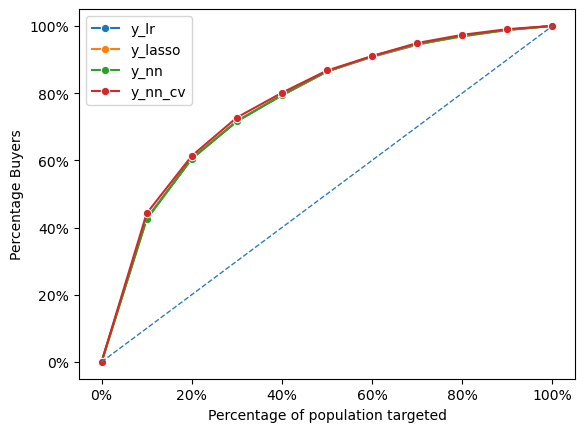

In [66]:
# no meaningful difference in performance visible
fig = rsm.gains_plot(eval_dat.query("training == 0"), "buyer_yes", 1, models[0:4])

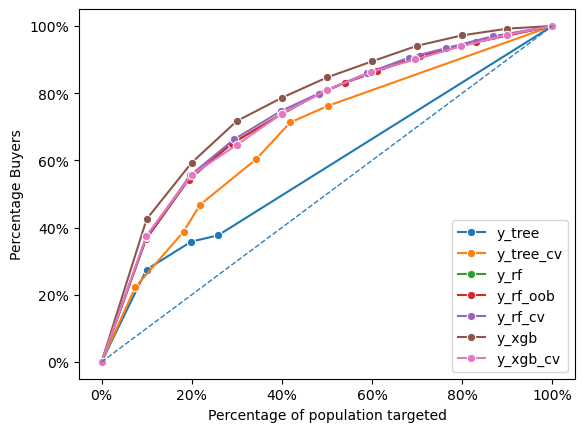

In [67]:
fig = rsm.gains_plot(eval_dat.query("training == 0"), "buyer_yes", 1, models[4:])

Summarize performance across all models in both training and test

In [68]:
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}
perf = rsm.evalbin(dct, "buyer_yes", 1, models, cost=0.5, margin=6)
perf

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,training,y_lr,2356,8624,23211,809,35000,0.744,0.729,0.215,0.333,0.730,0.224,8646.0,0.545,1.575,0.314,0.814
1,training,y_lasso,2342,8501,23334,823,35000,0.740,0.733,0.216,0.334,0.734,0.226,8630.5,0.544,1.592,0.310,0.814
2,training,y_nn,2327,8373,23462,838,35000,0.735,0.737,0.217,0.336,0.737,0.228,8612.0,0.543,1.610,0.306,0.814
3,training,y_nn_cv,2337,8152,23683,828,35000,0.738,0.744,0.223,0.342,0.743,0.236,8777.5,0.554,1.674,0.300,0.822
4,training,y_tree,3006,1528,30307,159,35000,0.950,0.952,0.663,0.781,0.952,0.755,15769.0,0.995,6.956,0.130,0.994
5,training,y_tree_cv,1161,5290,26545,2004,35000,0.367,0.834,0.180,0.241,0.792,0.137,3740.5,0.236,1.160,0.184,0.677
6,training,y_rf,3165,3111,28724,0,35000,1.000,0.902,0.504,0.670,0.911,0.625,15852.0,1.000,5.052,0.179,1.000
7,training,y_rf_oob,2178,9696,22139,987,35000,0.688,0.695,0.183,0.290,0.695,0.171,7131.0,0.450,1.201,0.339,0.749
8,training,y_rf_cv,2208,9562,22273,957,35000,0.698,0.700,0.188,0.296,0.699,0.179,7363.0,0.464,1.251,0.336,0.761
9,training,y_xgb,2459,8231,23604,706,35000,0.777,0.741,0.230,0.355,0.745,0.250,9409.0,0.594,1.760,0.305,0.842


In [69]:
# sort on any metric you like to get the "best" model
perf[perf.Type == "test"].sort_values(by="profit", ascending=False).reset_index(
    drop=True
)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,test,y_nn_cv,993,3553,10090,364,15000,0.732,0.740,0.218,0.336,0.739,0.229,3685.0,1.000,1.621,0.303,0.813
1,test,y_xgb,977,3592,10051,380,15000,0.720,0.737,0.214,0.330,0.735,0.221,3577.5,0.971,1.566,0.305,0.801
2,test,y_nn,979,3631,10012,378,15000,0.721,0.734,0.212,0.328,0.733,0.219,3569.0,0.969,1.548,0.307,0.806
3,test,y_lasso,980,3678,9965,377,15000,0.722,0.730,0.210,0.326,0.730,0.216,3551.0,0.964,1.525,0.311,0.806
4,test,y_lr,984,3741,9902,373,15000,0.725,0.726,0.208,0.324,0.726,0.213,3541.5,0.961,1.499,0.315,0.806
5,test,y_rf_cv,948,4092,9551,409,15000,0.699,0.700,0.188,0.296,0.700,0.179,3168.0,0.860,1.257,0.336,0.765
6,test,y_rf,945,4081,9562,412,15000,0.696,0.701,0.188,0.296,0.700,0.179,3157.0,0.857,1.256,0.335,0.760
7,test,y_rf_oob,945,4081,9562,412,15000,0.696,0.701,0.188,0.296,0.700,0.179,3157.0,0.857,1.256,0.335,0.760
8,test,y_xgb_cv,432,779,12864,925,15000,0.318,0.943,0.357,0.336,0.886,0.275,1986.5,0.539,3.281,0.081,0.759
9,test,y_tree_cv,526,2200,11443,831,15000,0.388,0.839,0.193,0.258,0.798,0.156,1793.0,0.487,1.315,0.182,0.680


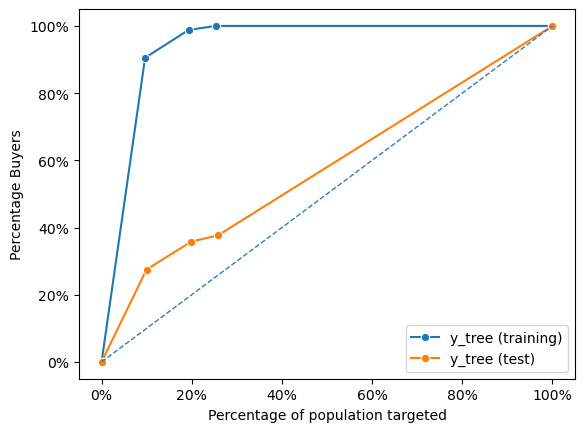

In [70]:
# compare gains from decision tree in training vs test
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}
fig = rsm.gains_plot(dct, "buyer_yes", 1, "y_tree")

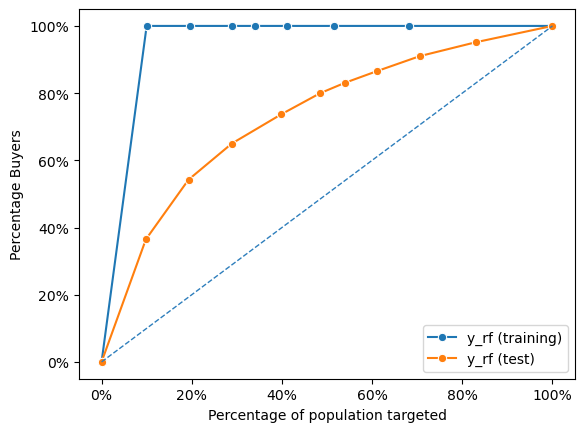

In [71]:
# compare gains for RandomForest in training vs test without OOB
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}
fig = rsm.gains_plot(dct, "buyer_yes", 1, "y_rf")

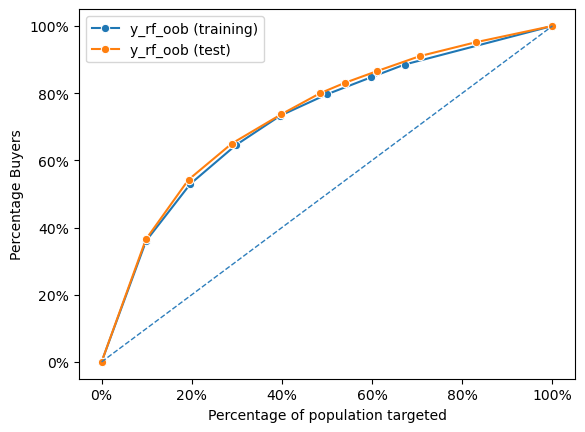

In [72]:
# compare gains for RandomForest (OOB) in training vs test with OOB
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}
fig = rsm.gains_plot(dct, "buyer_yes", 1, "y_rf_oob")

When using any machine learning model you should *always* create plots of the (1) relative importance of variables the (2) the direction of the effect. Use permutation importance for the importance plot and use partial dependence plots to get a sense of the direction of the effect (positive, negative, non-linear)

In [73]:
clf_xgb = xgb.XGBClassifier(
    max_depth=xgb_cv.best_params_["max_depth"],
    n_estimators=xgb_cv.best_params_["n_estimators"],
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="auc",
    random_state=1234,
).fit(X[training == 1], y[training == 1], verbose=True)

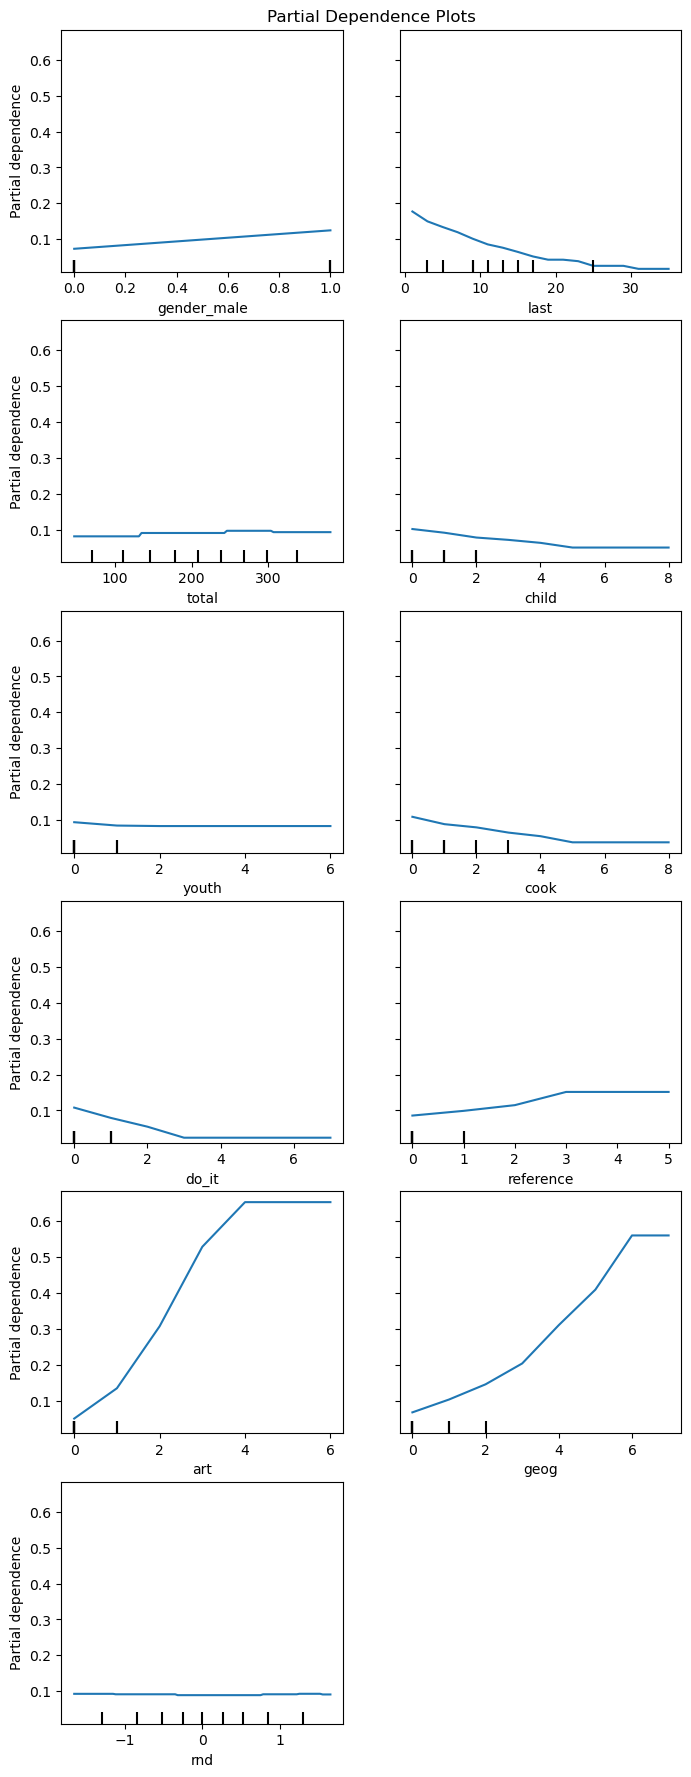

In [74]:
figsize = (8, len(Xs.columns) * 2)
fig, ax = plt.subplots(figsize=figsize)
ax.set_title("Partial Dependence Plots")
fig = pdp.from_estimator(
    clf_xgb, X, X.columns, ax=ax, n_cols=2
)

In [75]:
def importance(clf, X, y, cn):
    imp = permutation_importance(
        clf, X, y, scoring="roc_auc", n_repeats=10, random_state=1234
    )
    data = pd.DataFrame(imp.importances.T)
    data.columns = cn
    order = data.agg("mean").sort_values(ascending=False).index
    fig = sns.barplot(
        x="value", y="variable", color="slateblue", data=pd.melt(data[order])
    )
    fig.set(title="Permutation Importances", xlabel=None, ylabel=None)
    return fig

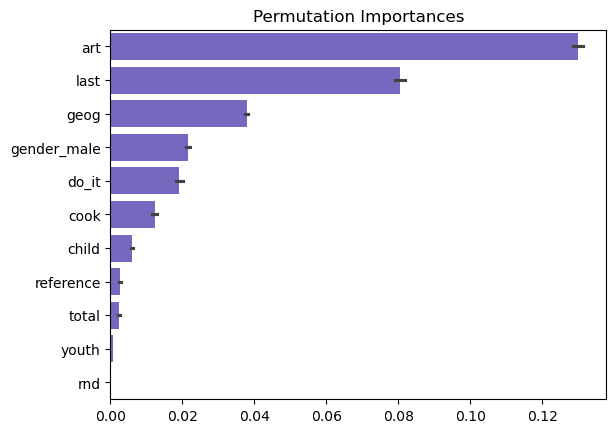

In [76]:
fig = importance(clf_xgb, X, y, X.columns)